# YOLO26 vs YOLO11 Benchmark on VisDrone

Independent verification of Ultralytics YOLO26 claims:
- **43% faster CPU inference** (ONNX)
- **Better small object detection** (ProgLoss + STAL)
- **NMS-free end-to-end inference**

Dataset: VisDrone2019-DET (~90% small objects)

Author: [Murat Raimbekov](https://github.com/raimbekovm)

In [1]:
!pip install -q ultralytics>=8.4.0 pycocotools onnx onnxruntime onnxsim

In [2]:
import os
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import onnxruntime as ort
from ultralytics import YOLO

print(f"PyTorch {torch.__version__}, CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch 2.8.0+cu126, CUDA: True
GPU: Tesla T4


In [3]:
CONFIG = {
    'epochs': 50,
    'batch': 16,
    'imgsz': 640,
    'data': 'VisDrone.yaml',
    'device': 0,
    'workers': 4,
}

## Training

In [4]:
YOLO26_WEIGHTS = 'runs/yolo26n/weights/best.pt'

if os.path.exists(YOLO26_WEIGHTS):
    print(f"Weights exist: {YOLO26_WEIGHTS}, skipping training")
else:
    yolo26 = YOLO('yolo26n.pt')
    yolo26.train(
        data=CONFIG['data'],
        epochs=CONFIG['epochs'],
        batch=CONFIG['batch'],
        imgsz=CONFIG['imgsz'],
        device=CONFIG['device'],
        workers=CONFIG['workers'],
        project='runs',
        name='yolo26n',
        exist_ok=True,
    )

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=VisDrone.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolo26n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

In [5]:
YOLO11_WEIGHTS = 'runs/yolo11n/weights/best.pt'

if os.path.exists(YOLO11_WEIGHTS):
    print(f"Weights exist: {YOLO11_WEIGHTS}, skipping training")
else:
    yolo11 = YOLO('yolo11n.pt')
    yolo11.train(
        data=CONFIG['data'],
        epochs=CONFIG['epochs'],
        batch=CONFIG['batch'],
        imgsz=CONFIG['imgsz'],
        device=CONFIG['device'],
        workers=CONFIG['workers'],
        project='runs',
        name='yolo11n',
        exist_ok=True,
    )

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=VisDrone.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolo11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

## Validation

In [6]:
yolo26_trained = YOLO(YOLO26_WEIGHTS)
yolo11_trained = YOLO(YOLO11_WEIGHTS)

def get_model_info(model):
    n_params = sum(p.numel() for p in model.model.parameters())
    n_layers = len(list(model.model.modules()))
    return n_params, n_layers

params26, layers26 = get_model_info(yolo26_trained)
params11, layers11 = get_model_info(yolo11_trained)
print(f"YOLO26n: {params26/1e6:.2f}M params, {layers26} layers")
print(f"YOLO11n: {params11/1e6:.2f}M params, {layers11} layers")

val26 = yolo26_trained.val(data=CONFIG['data'], imgsz=CONFIG['imgsz'], device=CONFIG['device'])
val11 = yolo11_trained.val(data=CONFIG['data'], imgsz=CONFIG['imgsz'], device=CONFIG['device'])

metrics = pd.DataFrame({
    'Model': ['YOLO26n', 'YOLO11n'],
    'Params_M': [params26/1e6, params11/1e6],
    'mAP50': [val26.box.map50, val11.box.map50],
    'mAP50-95': [val26.box.map, val11.box.map],
    'Precision': [val26.box.mp, val11.box.mp],
    'Recall': [val26.box.mr, val11.box.mr],
})
metrics

YOLO26n: 2.51M params, 454 layers
YOLO11n: 2.59M params, 320 layers
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26n summary (fused): 122 layers, 2,376,786 parameters, 0 gradients, 5.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2465.3±696.2 MB/s, size: 125.2 KB)
val: Scanning /kaggle/working/datasets/VisDrone/labels/val.cache... 548 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 548/548 209.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 5.1it/s 6.9s0.1s
                   all        548      38759      0.376      0.298      0.278      0.155
            pedestrian        520       8844      0.335      0.382       0.32       0.13
                people        482       5125      0.381       0.27      0.247     0.0859
               bicycle        364       1287      0.168     0.0712     0.0536     0.0203
                   car        515      14064    

,Model,Params_M,mAP50,mAP50-95,Precision,Recall
0,YOLO26n,2.50770,0.277926,0.154901,0.375911,0.297583
1,YOLO11n,2.59179,0.302009,0.171208,0.409141,0.311605


## Speed Benchmark

Ultralytics benchmarks CPU speed using ONNX format. We test both GPU (PyTorch) and CPU (ONNX).

In [7]:
def benchmark_gpu(model, warmup=50, runs=200, imgsz=640):
    dummy = np.random.randint(0, 255, (imgsz, imgsz, 3), dtype=np.uint8)
    for _ in range(warmup):
        model.predict(dummy, device=0, verbose=False)
    torch.cuda.synchronize()
    
    times = []
    for _ in range(runs):
        t0 = time.perf_counter()
        model.predict(dummy, device=0, verbose=False)
        torch.cuda.synchronize()
        times.append((time.perf_counter() - t0) * 1000)
    return np.mean(times), np.std(times)


def benchmark_onnx(onnx_path, warmup=30, runs=100, imgsz=640):
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    input_name = sess.get_inputs()[0].name
    dummy = np.random.rand(1, 3, imgsz, imgsz).astype(np.float32)
    
    for _ in range(warmup):
        sess.run(None, {input_name: dummy})
    
    times = []
    for _ in range(runs):
        t0 = time.perf_counter()
        sess.run(None, {input_name: dummy})
        times.append((time.perf_counter() - t0) * 1000)
    return np.mean(times), np.std(times)

In [8]:
gpu26, gpu26_std = benchmark_gpu(yolo26_trained)
gpu11, gpu11_std = benchmark_gpu(yolo11_trained)
print(f"GPU - YOLO26n: {gpu26:.2f}±{gpu26_std:.2f}ms, YOLO11n: {gpu11:.2f}±{gpu11_std:.2f}ms")

GPU - YOLO26n: 10.47±0.31ms, YOLO11n: 9.41±0.58ms


In [9]:
onnx26 = yolo26_trained.export(format='onnx', imgsz=CONFIG['imgsz'], simplify=True)
onnx11 = yolo11_trained.export(format='onnx', imgsz=CONFIG['imgsz'], simplify=True)

onnx26_size = os.path.getsize(onnx26) / 1e6
onnx11_size = os.path.getsize(onnx11) / 1e6
print(f"ONNX size - YOLO26n: {onnx26_size:.1f}MB, YOLO11n: {onnx11_size:.1f}MB")

cpu26, cpu26_std = benchmark_onnx(onnx26)
cpu11, cpu11_std = benchmark_onnx(onnx11)
print(f"CPU ONNX - YOLO26n: {cpu26:.2f}±{cpu26_std:.2f}ms, YOLO11n: {cpu11:.2f}±{cpu11_std:.2f}ms")

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/yolo26n/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.1 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 280ms
Prepared 2 packages in 2.94s
Installed 2 packages in 102ms
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 3.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.1 opset 22...


/usr/local/lib/python3.12/dist-packages/torch/onnx/utils.py:1397: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/onnx/symbolic_opset9.py:5350: UserWarning: Exporting aten::index operator of advanced indexing in opset 22 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 5.4s, saved as 'runs/yolo26n/weights/best.onnx' (9.4 MB)

Export complete (5.7s)
Results saved to /kaggle/working/runs/yolo26n/weights
Predict:         yolo predict task=detect model=runs/yolo26n/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=runs/yolo26n/weights/best.onnx imgsz=640 data=/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/datasets/VisDrone.yaml  
Visualize:       https://netron.app
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from 'runs/yolo11n/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (5.2 MB)

ONNX: starting export with onnx 1.20.1 opset 22...
ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 1.6s, saved as 'runs/yolo11n/weights/best.onnx' (10.1 MB)

Export complete (1.8s)
Results saved to /kaggle/working/runs/yolo11n/weights
Predict:         yolo predict task=

In [10]:
speed_df = pd.DataFrame([
    {'Model': 'YOLO26n', 'Device': 'GPU', 'Time_ms': gpu26, 'Std': gpu26_std},
    {'Model': 'YOLO11n', 'Device': 'GPU', 'Time_ms': gpu11, 'Std': gpu11_std},
    {'Model': 'YOLO26n', 'Device': 'CPU-ONNX', 'Time_ms': cpu26, 'Std': cpu26_std},
    {'Model': 'YOLO11n', 'Device': 'CPU-ONNX', 'Time_ms': cpu11, 'Std': cpu11_std},
])

model_df = pd.DataFrame([
    {'Model': 'YOLO26n', 'Params_M': params26/1e6, 'ONNX_MB': onnx26_size},
    {'Model': 'YOLO11n', 'Params_M': params11/1e6, 'ONNX_MB': onnx11_size},
])

cpu_speedup = (1 - cpu26 / cpu11) * 100
print(f"CPU Speedup: YOLO26 is {cpu_speedup:+.1f}% vs YOLO11 (claimed: +43%)")
print(f"\nModel Size:")
print(model_df.to_string(index=False))

CPU Speedup: YOLO26 is -27.2% vs YOLO11 (claimed: +43%)

Model Size:
  Model  Params_M   ONNX_MB
YOLO26n   2.50770  9.812339
YOLO11n   2.59179 10.611246


## COCO Evaluation by Object Size

Testing ProgLoss + STAL claim for small object detection.

In [22]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image

CLASSES = ['pedestrian', 'people', 'bicycle', 'car', 'van',
           'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']

DATA_PATH = Path('/kaggle/working/datasets/VisDrone')


def create_coco_gt(data_path):
    images_dir = data_path / 'images' / 'val'
    labels_dir = data_path / 'labels' / 'val'
    
    coco = {
        'info': {'description': 'VisDrone validation set'},
        'licenses': [],
        'images': [],
        'annotations': [],
        'categories': [{'id': i, 'name': n} for i, n in enumerate(CLASSES)]
    }
    
    ann_id = 0
    img_files = list(sorted(images_dir.glob('*.jpg')))
    print(f"Found {len(img_files)} validation images")
    
    for img_id, img_path in enumerate(img_files):
        with Image.open(img_path) as im:
            w, h = im.size
        coco['images'].append({'id': img_id, 'file_name': img_path.name, 'width': w, 'height': h})
        
        label_path = labels_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            for line in open(label_path):
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(parts[0])
                    xc, yc, bw, bh = map(float, parts[1:5])
                    xc, yc, bw, bh = xc*w, yc*h, bw*w, bh*h
                    coco['annotations'].append({
                        'id': ann_id, 'image_id': img_id, 'category_id': cls,
                        'bbox': [xc-bw/2, yc-bh/2, bw, bh], 'area': bw*bh, 'iscrowd': 0
                    })
                    ann_id += 1
    
    print(f"Created {len(coco['annotations'])} annotations")
    return coco


def get_predictions(model, data_path, device=0):
    images_dir = data_path / 'images' / 'val'
    preds = []
    img_files = list(sorted(images_dir.glob('*.jpg')))
    print(f"Running predictions on {len(img_files)} images...")
    
    for img_id, img_path in enumerate(img_files):
        results = model.predict(str(img_path), device=device, verbose=False)[0]
        if results.boxes is not None:
            for box, conf, cls in zip(results.boxes.xyxy.cpu().numpy(),
                                       results.boxes.conf.cpu().numpy(),
                                       results.boxes.cls.cpu().numpy()):
                x1, y1, x2, y2 = box
                preds.append({
                    'image_id': img_id, 'category_id': int(cls),
                    'bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                    'score': float(conf)
                })
    
    print(f"Got {len(preds)} predictions")
    return preds

In [24]:
gt_dict = create_coco_gt(DATA_PATH)
coco_gt = COCO()
coco_gt.dataset = gt_dict
coco_gt.createIndex()

size_results = []
for name, model in [('YOLO26n', yolo26_trained), ('YOLO11n', yolo11_trained)]:
    preds = get_predictions(model, DATA_PATH)
    coco_dt = coco_gt.loadRes(preds)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    size_results.append({
        'Model': name,
        'AP': coco_eval.stats[0],
        'AP_small': coco_eval.stats[3],
        'AP_medium': coco_eval.stats[4],
        'AP_large': coco_eval.stats[5],
    })

size_df = pd.DataFrame(size_results)
size_df

Found 548 validation images
Created 38759 annotations
creating index...
index created!
Running predictions on 548 images...
Got 19415 predictions
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.56s).
Accumulating evaluation results...
DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.108
 

,Model,AP,AP_small,AP_medium,AP_large
0,YOLO26n,0.102935,0.042481,0.163854,0.326675
1,YOLO11n,0.125709,0.050552,0.205366,0.383197


## Results

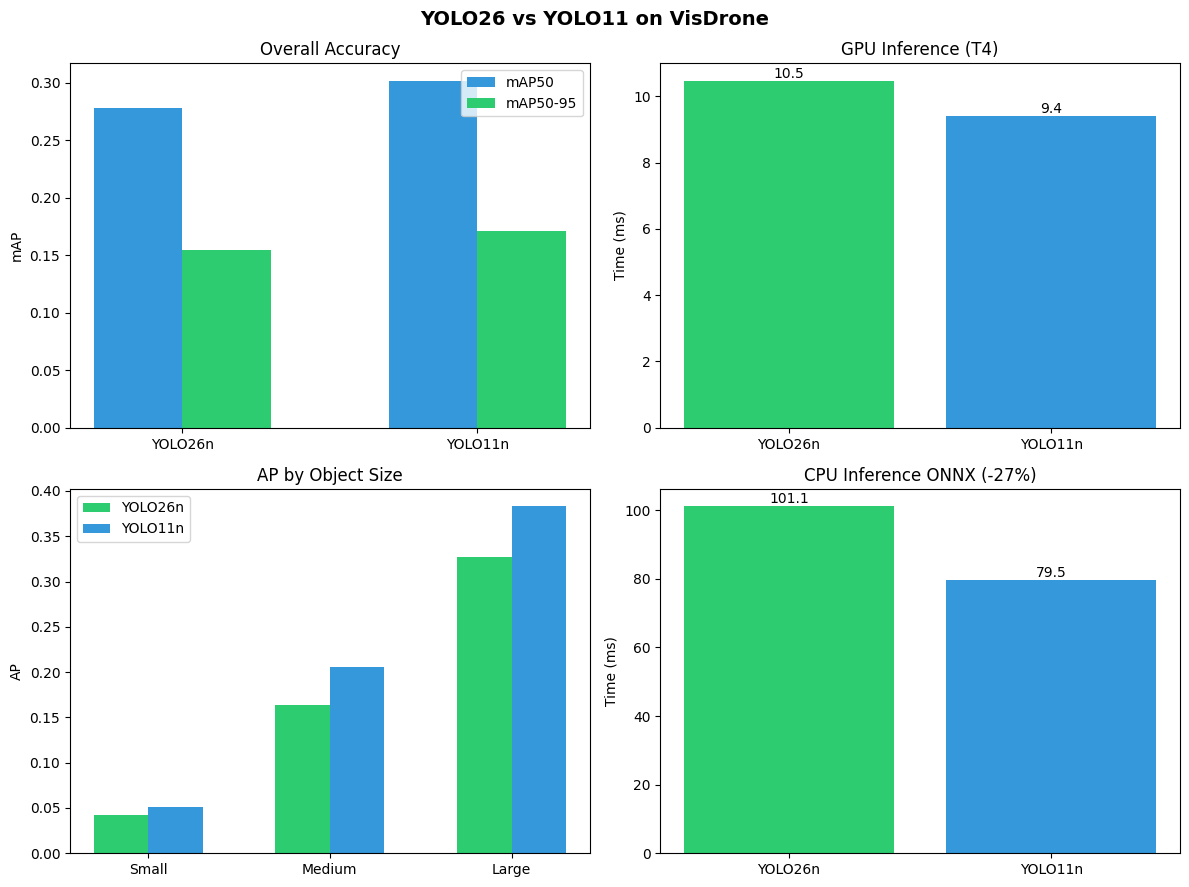

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
colors = {'YOLO26n': '#2ecc71', 'YOLO11n': '#3498db'}

# mAP
ax = axes[0, 0]
x = np.arange(2)
ax.bar(x - 0.15, metrics['mAP50'], 0.3, label='mAP50', color='#3498db')
ax.bar(x + 0.15, metrics['mAP50-95'], 0.3, label='mAP50-95', color='#2ecc71')
ax.set_xticks(x)
ax.set_xticklabels(metrics['Model'])
ax.set_ylabel('mAP')
ax.set_title('Overall Accuracy')
ax.legend()

# GPU Speed
ax = axes[0, 1]
bars = ax.bar(['YOLO26n', 'YOLO11n'], [gpu26, gpu11], color=[colors['YOLO26n'], colors['YOLO11n']])
ax.set_ylabel('Time (ms)')
ax.set_title('GPU Inference (T4)')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom')

# AP by Size
ax = axes[1, 0]
x = np.arange(3)
ax.bar(x - 0.15, [size_df[size_df['Model']=='YOLO26n'][c].values[0] for c in ['AP_small', 'AP_medium', 'AP_large']], 0.3, label='YOLO26n', color=colors['YOLO26n'])
ax.bar(x + 0.15, [size_df[size_df['Model']=='YOLO11n'][c].values[0] for c in ['AP_small', 'AP_medium', 'AP_large']], 0.3, label='YOLO11n', color=colors['YOLO11n'])
ax.set_xticks(x)
ax.set_xticklabels(['Small', 'Medium', 'Large'])
ax.set_ylabel('AP')
ax.set_title('AP by Object Size')
ax.legend()

# CPU ONNX Speed
ax = axes[1, 1]
bars = ax.bar(['YOLO26n', 'YOLO11n'], [cpu26, cpu11], color=[colors['YOLO26n'], colors['YOLO11n']])
ax.set_ylabel('Time (ms)')
ax.set_title(f'CPU Inference ONNX ({cpu_speedup:+.0f}%)')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom')

plt.suptitle('YOLO26 vs YOLO11 on VisDrone', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('benchmark_results.png', dpi=150)
plt.show()

In [26]:
small_diff = size_df[size_df['Model']=='YOLO26n']['AP_small'].values[0] - size_df[size_df['Model']=='YOLO11n']['AP_small'].values[0]

print("="*60)
print("SUMMARY")
print("="*60)
print(f"\nModel Size: YOLO26n={params26/1e6:.2f}M, YOLO11n={params11/1e6:.2f}M")
print(f"ONNX Size: YOLO26n={onnx26_size:.1f}MB, YOLO11n={onnx11_size:.1f}MB")
print(f"\nAccuracy (mAP50): YOLO26n={metrics[metrics['Model']=='YOLO26n']['mAP50'].values[0]:.3f}, YOLO11n={metrics[metrics['Model']=='YOLO11n']['mAP50'].values[0]:.3f}")
print(f"Small Object AP: YOLO26n={size_df[size_df['Model']=='YOLO26n']['AP_small'].values[0]:.4f}, YOLO11n={size_df[size_df['Model']=='YOLO11n']['AP_small'].values[0]:.4f} ({small_diff:+.4f})")
print(f"\nGPU Speed (T4): YOLO26n={gpu26:.2f}ms, YOLO11n={gpu11:.2f}ms")
print(f"CPU Speed (ONNX): YOLO26n={cpu26:.2f}ms, YOLO11n={cpu11:.2f}ms ({cpu_speedup:+.1f}%, claimed +43%)")
print("="*60)

SUMMARY

Model Size: YOLO26n=2.51M, YOLO11n=2.59M
ONNX Size: YOLO26n=9.8MB, YOLO11n=10.6MB

Accuracy (mAP50): YOLO26n=0.278, YOLO11n=0.302
Small Object AP: YOLO26n=0.0425, YOLO11n=0.0506 (-0.0081)

GPU Speed (T4): YOLO26n=10.47ms, YOLO11n=9.41ms
CPU Speed (ONNX): YOLO26n=101.14ms, YOLO11n=79.53ms (-27.2%, claimed +43%)


In [28]:
metrics.to_csv('metrics.csv', index=False)
speed_df.to_csv('speed.csv', index=False)
size_df.to_csv('size_metrics.csv', index=False)
model_df.to_csv('model_info.csv', index=False)